In [11]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from scipy.stats import randint

# 1. Load the Wine Quality Dataset
df = pd.read_csv('winequality-red.csv', delimiter=';')
df


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [12]:
# 2. Data Preprocessing
df['quality_label'] = df['quality'].apply(lambda x: 1 if x > 6 else 0)  # Convert quality to binary classification
X = df.drop(columns=['quality', 'quality_label'])  # Features
y = df['quality_label']  # Target variable

# 3. Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# 5. Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5, n_jobs=-1, verbose=1, scoring='accuracy'
)
grid_search.fit(X_train_scaled, y_train)
print("Best hyperparameters (GridSearchCV):", grid_search.best_params_)

# 6. Hyperparameter Tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [3, 5, 10, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100, cv=5, n_jobs=-1, verbose=1, scoring='accuracy', random_state=42
)
random_search.fit(X_train_scaled, y_train)
print("Best hyperparameters (RandomizedSearchCV):", random_search.best_params_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best hyperparameters (GridSearchCV): {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameters (RandomizedSearchCV): {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 177}


Cross-Validation Scores: [0.87890625 0.9296875  0.88671875 0.92578125 0.91764706]
Mean Cross-Validation Accuracy: 0.907748161764706
Accuracy: 0.890625
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94       273
           1       0.69      0.47      0.56        47

    accuracy                           0.89       320
   macro avg       0.80      0.72      0.75       320
weighted avg       0.88      0.89      0.88       320



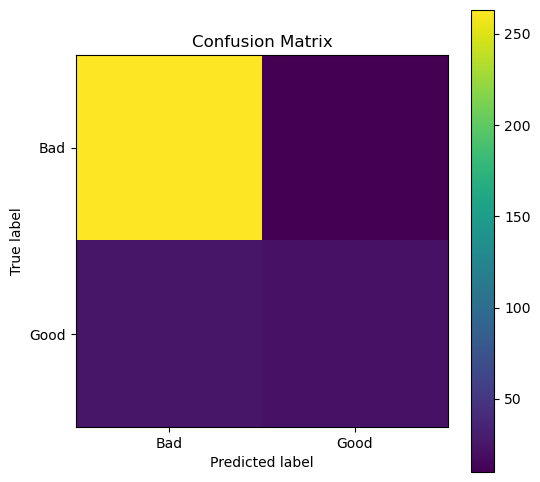

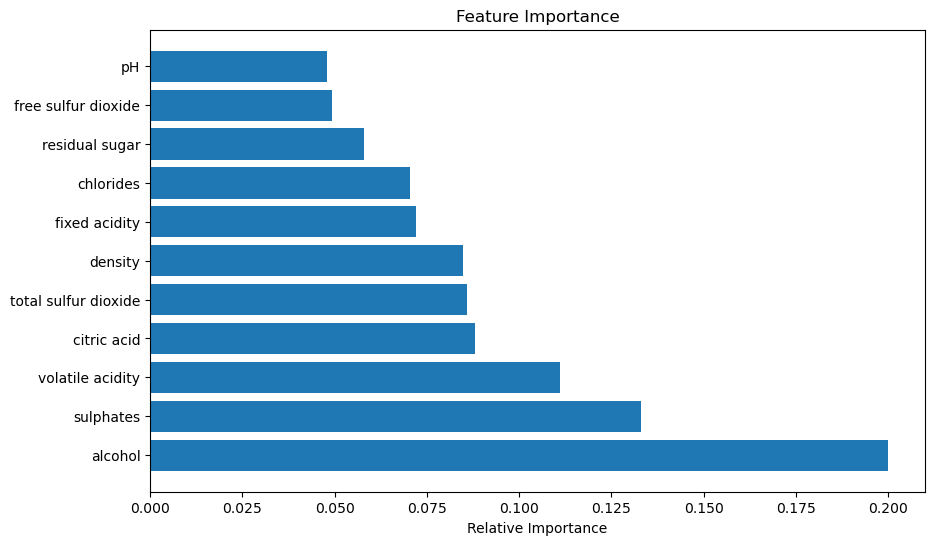

In [3]:
# 7. Cross-validation with the best model
best_rf = grid_search.best_estimator_
cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))

# 8. Train the final Random Forest model
final_rf = grid_search.best_estimator_
final_rf.fit(X_train_scaled, y_train)

# 9. Evaluate the Random Forest Model
y_pred = final_rf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='viridis')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(2), ['Bad', 'Good'])
plt.yticks(np.arange(2), ['Bad', 'Good'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# 10. Feature Importance
importances = final_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.xlabel("Relative Importance")
plt.show()

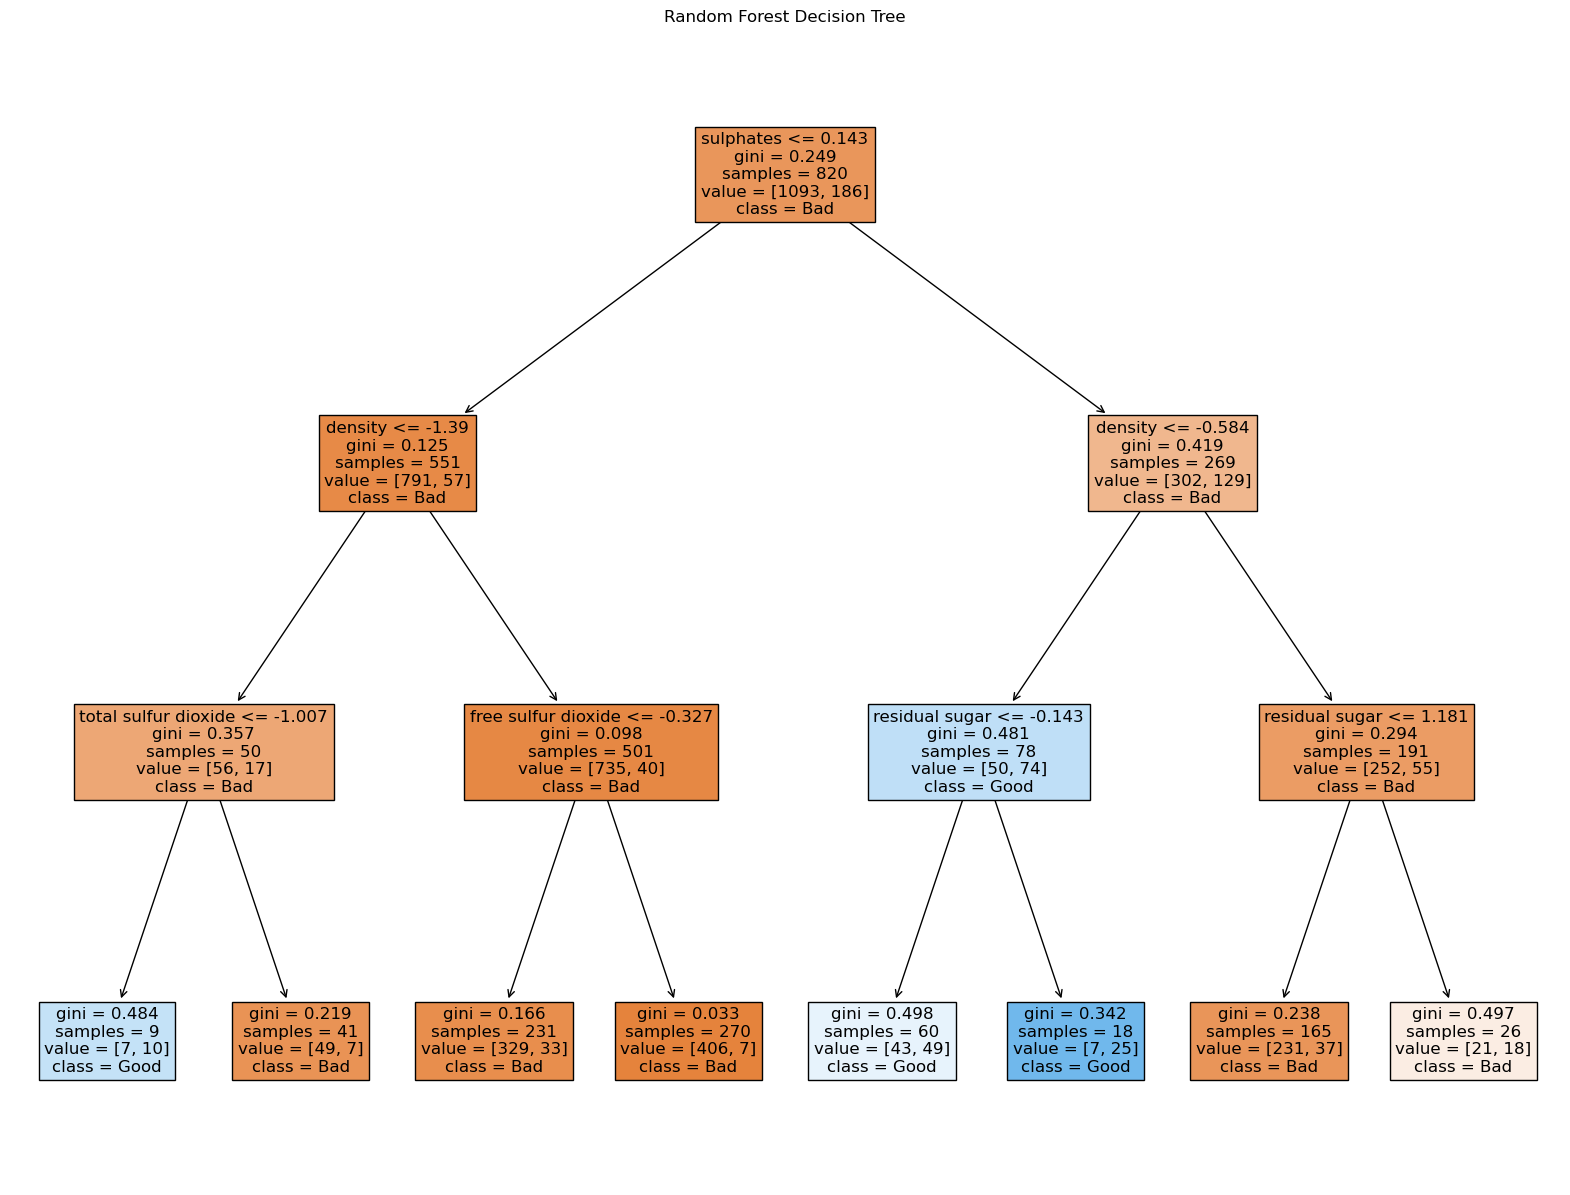

In [5]:
# 11. Visualize a Single Tree
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=3, min_samples_split=10, min_samples_leaf=5)
clf.fit(X_train_scaled, y_train)
# Convert X.columns to a list for feature_names
plt.figure(figsize=(20, 15))
plot_tree(
    clf.estimators_[0], 
    filled=True, 
    feature_names=X.columns.tolist(), 
    class_names=["Bad", "Good"], 
    max_depth=3, 
    fontsize=12
)
plt.title("Random Forest Decision Tree")
plt.show()

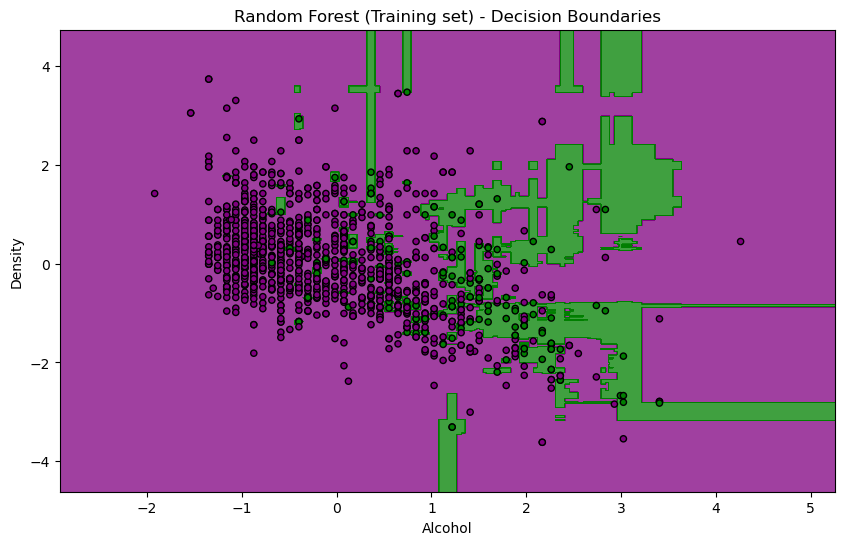

In [6]:
# 12. Decision Boundary Visualization (Training Set)
X_vis = X[['alcohol', 'density']]  # Choose two features for visualization
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(X_vis, y, test_size=0.2, random_state=42)
X_train_vis_scaled = scaler.fit_transform(X_train_vis)
X_test_vis_scaled = scaler.transform(X_test_vis)

clf_vis = RandomForestClassifier(n_estimators=100, random_state=42)
clf_vis.fit(X_train_vis_scaled, y_train_vis)

# Decision Boundary Plot
X1, X2 = np.meshgrid(
    np.arange(X_train_vis_scaled[:, 0].min() - 1, X_train_vis_scaled[:, 0].max() + 1, 0.01),
    np.arange(X_train_vis_scaled[:, 1].min() - 1, X_train_vis_scaled[:, 1].max() + 1, 0.01)
)
Z = clf_vis.predict(np.c_[X1.ravel(), X2.ravel()]).reshape(X1.shape)
plt.figure(figsize=(10, 6))
plt.contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('purple', 'green')))
plt.scatter(X_train_vis_scaled[:, 0], X_train_vis_scaled[:, 1], c=y_train_vis, cmap=ListedColormap(('purple', 'green')), edgecolor='black', s=20)
plt.title("Random Forest (Training set) - Decision Boundaries")
plt.xlabel('Alcohol')
plt.ylabel('Density')
plt.show()

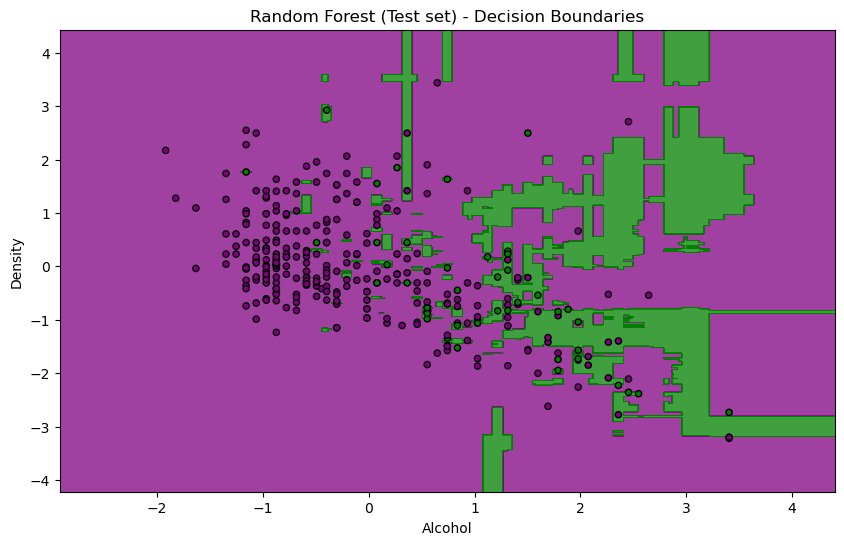

In [7]:
# Decision Boundary Visualization (Test Set)
X1, X2 = np.meshgrid(
    np.arange(X_test_vis_scaled[:, 0].min() - 1, X_test_vis_scaled[:, 0].max() + 1, 0.01),
    np.arange(X_test_vis_scaled[:, 1].min() - 1, X_test_vis_scaled[:, 1].max() + 1, 0.01)
)
Z = clf_vis.predict(np.c_[X1.ravel(), X2.ravel()]).reshape(X1.shape)
plt.figure(figsize=(10, 6))
plt.contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('purple', 'green')))
plt.scatter(X_test_vis_scaled[:, 0], X_test_vis_scaled[:, 1], c=y_test_vis, cmap=ListedColormap(('purple', 'green')), edgecolor='black', s=20)
plt.title("Random Forest (Test set) - Decision Boundaries")
plt.xlabel('Alcohol')
plt.ylabel('Density')
plt.show()
